In [84]:
#import the necessary libraries for pandas and plotting
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
#import the glob library to retrieve all the files in a folder
import glob
#import the necessary libraries
from scipy.optimize import curve_fit

#declare some variables
line_PEW = 2
line_PLQY = 3


#create a function that reads the data from a PLQY file
def read_data(file):
    df = pd.read_csv(file, sep='\s+', skiprows=8, header=None)
    return df


#create a function that opens a file, and returns the last number of the n-line
def get_number_in_line(file, line):
    with open(file) as f:
        for i, l in enumerate(f):
            if i == line:
                return float(l.split()[-1])
            

#create a function that simplifies the file name
def simplify_name(file):
    #keep only the characters before the "_"
    string1 = file.split("/")[-1].split("_")[0]
    #replace the backslash with a forward slash
    string2 = string1.replace("\\", "/")
    #keep only the characters after the first last slash
    string3 = string2.split("/")[-1]
    #keep only the 5 first characters
    string4 = string3[:5]
    #put all the characters in uppercase
    string5 = string4.upper()
    return string5


def func(x, a, b, c, d):
    return a * np.exp(-(x - b)**2 / (2 * c**2)) + d


#create a function that finds a gaussian function that fits the data
def gaussian_fitting(data):
    #define the gaussian function

    p_a = max(data[1])
    #set b equals to the x value of the maximum of the data
    p_b = data[0][np.argmax(data[1])]
    #for p_c, use the value of the difference between the values at half the maximum
    #find the index of the value that is closest to half the maximum
    index = (np.abs(data[1] - max(data[1])/2)).argmin()
    #find the value of the x axis at that index
    p_c = abs(data[0][index] - p_b)
    p_d = min(data[1])

    p = [p_a, p_b, p_c, p_d]

    def func(x, a, b, c, d):
        return a * np.exp(-(x - b)**2 / (2 * c**2)) + d
    #fit the data with the gaussian function
    popt, pcov = curve_fit(func, data[0], data[1], p0 = p)
    return popt

#create a function that normalizes the data
def normalize_data(data):
    #find the maximum of the data
    max_data = max(data[1])
    #normalize the data
    data[1] = data[1] / max_data
    return data


## Plotting PLQY

found 12 files


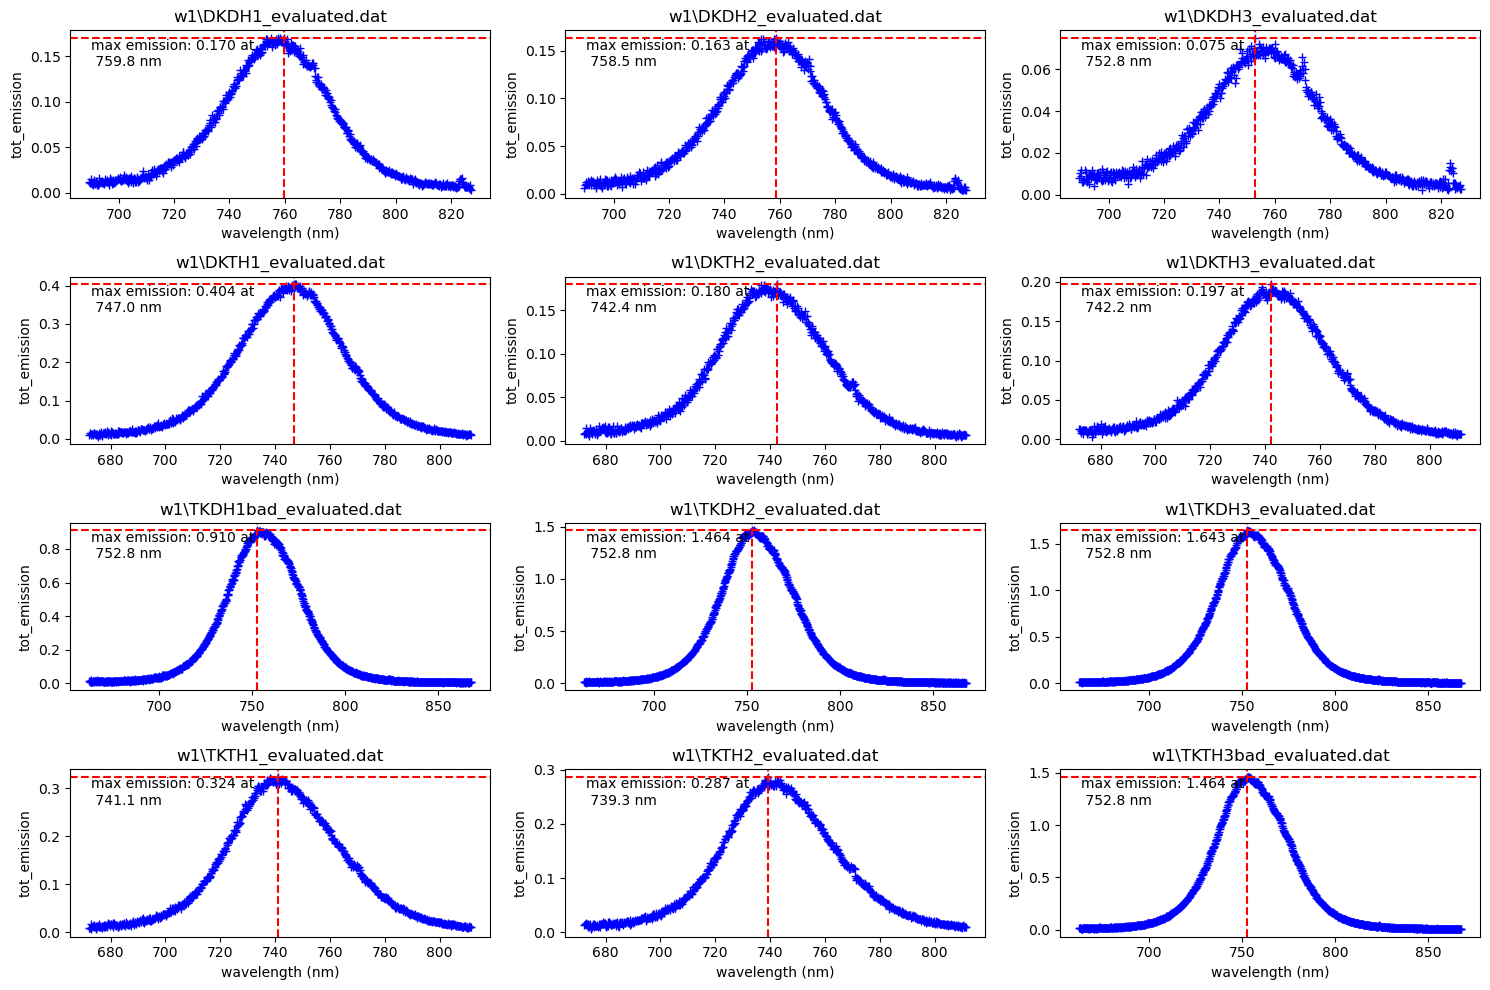

In [89]:
#ask for which folder to use
folder = input("Which folder would you like to use? ")


#retrieve all the files that end with evaluated.dat in the folder chosen by the user
files = glob.glob("PLQY/" + folder + "/*evaluated.dat")

print("found " + str(len(files)) + " files")

#create a dataframe for each file
dfs = []
for file in files:
    dfs.append(read_data(file))

#for each dataframe, name the columns "wavelength" and "PLQY"
for df in dfs:
    df.columns = ['wavelength', 'tot_emission']

#create subplots for each dataframe with 3 columns and x rows

#calculate the number of rows
rows = len(dfs) // 3
fig, axs = plt.subplots(rows, 3, figsize=(15, 10), sharey=False)

#plot the data in each subplot
for i, df in enumerate(dfs):
    axs[i // 3, i % 3].plot(df['wavelength'], df['tot_emission'], 'b+')
    axs[i // 3, i % 3].set_title('w1')
    axs[i // 3, i % 3].set_xlabel('wavelength (nm)')
    axs[i // 3, i % 3].set_ylabel('tot_emission')

#name the subplots with the file name
for i, file in enumerate(files):
    axs[i // 3, i % 3].set_title(file.split('/')[-1])

#add vertical space between the subplots
fig.tight_layout()

#place a vertical line at the maximum of the PLQY
for i, df in enumerate(dfs):
    axs[i // 3, i % 3].axvline(df['wavelength'][df['tot_emission'].idxmax()], color='r', linestyle='--')

#place a horizontal line at the maximum of the PLQY
for i, df in enumerate(dfs):
    axs[i // 3, i % 3].axhline(df['tot_emission'].max(), color='r', linestyle='--')

#as a legend write the maximum of the PLQY and the wavelength at which it occurs
#place the legend at the top left corner of the subplot
for i, df in enumerate(dfs):
    axs[i // 3, i % 3].text(0.05, 0.95, 'max emission: {:.3f} at \n {:.1f} nm'.format(df['tot_emission'].max(), df['wavelength'][df['tot_emission'].idxmax()]), transform=axs[i // 3, i % 3].transAxes, fontsize=10, verticalalignment='top')

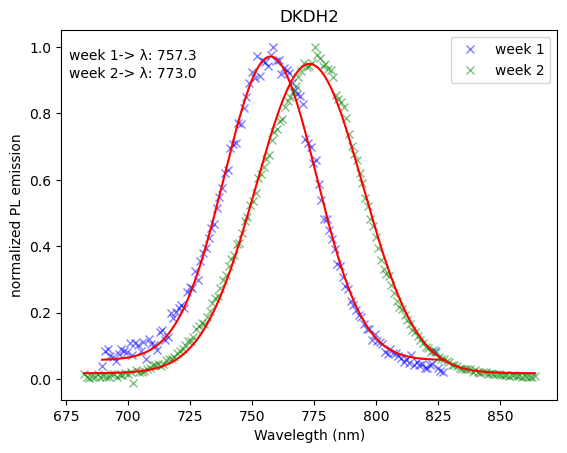

In [86]:
#ask the user the name of the file to display
#sample = input("Which sample would you like to display? ")

sample = "dkdh2"

#put the name in uppercase
sample = sample.upper()

index = 0
colors = ['b', 'g', 'c', 'm', 'y', 'k', 'w']

for folder in glob.glob("PLQY/*"):
    #for each file in the folder do
    for file in glob.glob(folder + "/*evaluated.dat"):
        name1 = simplify_name(file)
        if name1 == sample:
            #read the file
            df = read_data(file)
            #normalize the data
            df[1] = normalize_data(df)[1]
            popt = gaussian_fitting(df)
            #plot the data using a different color for each file
            plt.plot(df[0], df[1], colors[index] + "x", markevery=5, alpha=0.5)
            plt.plot(df[0], func(df[0], *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
            #add a legend with the index number
            index += 1
            plt.text(0.015, (1-0.05*index), 'week {:d}-> λ: {:.1f} '.format(index, popt[1]), transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
        lgd = []
        for i in range(0, (index)):
            lgd.append("week " + str(i + 1))
            lgd.append("_")
        plt.legend(lgd)
        plt.title(sample)
        #add a y label
        plt.ylabel("normalized PL emission")
        plt.xlabel("Wavelegth (nm)")
        #add a text box witht the p_b value
        

## Evolution of PLQY

In [15]:
#create a new dataframe with three columns with the names "sample", "PEW" and "PLQY"
df4 = pd.DataFrame(columns=['sample', 'PEW_1', 'PLQY_1'])

index = 1
#for each folder in the PLQY folder do
for folder in glob.glob("PLQY/*"):
    #if this is the first iteration
    if folder == "PLQY\\w1":
        #for each file in the folder do
        for file in glob.glob(folder + "/*evaluated.dat"):
            #get the simplified name of the file
            name = simplify_name(file)
            #get the number in the 3rd line
            number1 = get_number_in_line(file, line_PEW)
            #get the number in the 4th line
            number2 = get_number_in_line(file, line_PLQY)
            #add a new row to the dataframe with the name of the file, the number in the 3rd line and the number in the 4th line
            df4 = df4.append({'sample': name, 'PEW_1': number1, 'PLQY_1': number2}, ignore_index=True)
    else:
        df4['PEW_' + str(index)] = 0
        df4['PLQY_' + str(index)] = 0
        #for each file in the folder do
        for file in glob.glob(folder + "/*evaluated.dat"):
            #get the simplified name of the file
            name = simplify_name(file)
            #get the number in the 3rd line
            number1 = get_number_in_line(file, line_PEW)
            #get the number in the 4th line
            number2 = get_number_in_line(file, line_PLQY)
            #fill the new columns with the values of PEW and PLQY starting from the beginning of the dataframe
            df4.loc[df4['sample'] == name, 'PEW_' + str(index)] = number1
            df4.loc[df4['sample'] == name, 'PLQY_' + str(index)] = number2
    index += 1

df4

,sample,PEW_1,PLQY_1,PEW_2,PLQY_2
0,DKDH1,760.0,0.00417,776,0.00392
1,DKDH2,758.0,0.00403,775,0.00348
2,DKDH3,753.0,0.00197,770,0.00216
3,DKTH1,747.0,0.00998,775,0.00164
4,DKTH2,742.0,0.00477,776,0.00149
5,DKTH3,742.0,0.00503,776,0.00648
6,TKDH1,753.0,0.01910,776,0.00650
7,TKDH2,753.0,0.03310,776,0.00813
8,TKDH3,753.0,0.03660,776,0.00469
9,TKTH1,741.0,0.00814,781,0.00296


Text(0.5, 1.0, 'PLQY at each week')

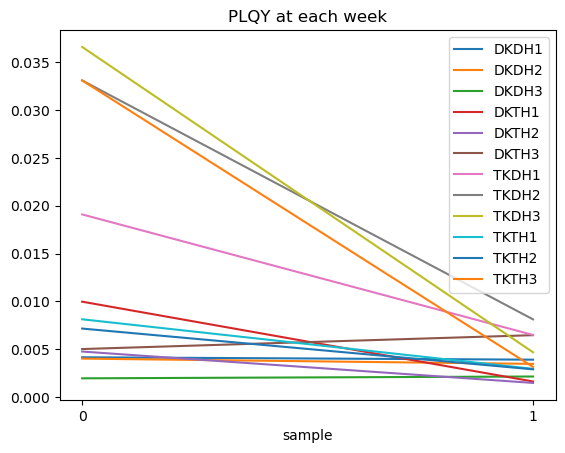

In [17]:
#transpose the dataframe
df5 = df4.transpose()
#use the first row as the header
df5.columns = df5.iloc[0]
#drop the first row
df5 = df5.drop(df5.index[0])
#reset the index
df5 = df5.reset_index()
#rename the index column
df5 = df5.rename(columns={'index': 'sample'})
#set the sample column as the index
df5 = df5.set_index('sample')

df5

#split the dataframe in two dataframes taking one row every two but keep the header
df6 = df5.iloc[::2, :]
df7 = df5.iloc[1::2, :]

#do the same for each column of the first dataframe
for i in range(0, len(df7.columns)):
    df7.iloc[:, i].plot.line()
#for the x axis use the sample column
plt.xticks(range(len(df7.index)), df7.index)
#replace the x axis labels with a list of numbers starting from 1 and ending at the number of rows in the dataframe
plt.xticks(range(len(df7.index)), range(0, len(df7.index)))
#add a legend
plt.legend(df7.columns)
#add a title
plt.title('PLQY at each week')



In [14]:
df7

sample,DKDH1,DKDH2,DKDH3,DKTH1,DKTH2,DKTH3,TKDH1,TKDH2,TKDH3,TKTH1,TKTH2,TKTH3
sample,,,,,,,,,,,,
PLQY_1,0.00417,0.00403,0.00197,0.00998,0.00477,0.00503,0.0191,0.0331,0.0366,0.00814,0.00717,0.0331
PLQY_2,0.00392,0.00348,0.00216,0.00164,0.00149,0.00648,0.0065,0.00813,0.00469,0.00296,0.00291,0.00316
PLQY_3,0.00392,0.00348,0.00216,0.00164,0.00149,0.00648,0.0065,0.00813,0.00469,0.00296,0.00291,0.00316


## Curve fitting

0.9947685388666753
[2.95526049e-01 7.42744185e+02 1.91911002e+01 1.56185763e-02]
742.744184780762
0.3111446253024011


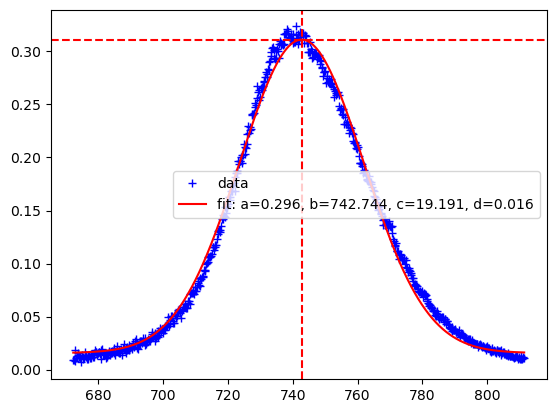

In [52]:
#import the library to fit a curve
from scipy.optimize import curve_fit

files = glob.glob("PLQY/" + "w1" + "/*evaluated.dat")
file = files[9]

df10 = pd.read_csv(file, sep='\s+', skiprows=8, header=None)


#gaussian function to fit the data
def func(x, a, b, c, d):
    return a * np.exp(-(x - b)**2 / (2 * c**2)) + d
    


#fit the data with the gaussian function
popt, pcov = curve_fit(func, df10[0], df10[1], p0=(0.15, 760, 40, 0.05))

#plot the data
plt.plot(df10[0], df10[1], 'b+', label='data')
#plot the fitting function
plt.plot(df10[0], func(df10[0], *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))

#compute the standard deviation of the parameters
perr = np.sqrt(np.diag(pcov))
#add the standard deviation to the legend
plt.legend(loc='best', prop={'size': 10})

#compute the r-squared value
residuals = df10[1] - func(df10[0], *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((df10[1] - np.mean(df10[1]))**2)
r_squared = 1 - (ss_res / ss_tot)

print(r_squared)

#print the values of the parameters
print(popt)

#add a line to the graph on the x axis at the value of the peak wavelength
plt.axvline(popt[1], color='r', linestyle='--')
#print the value of the peak wavelength
print("λ at max: " + popt[1])
#add a line to the graph on the y axis at the value of the peak emission
plt.axhline(func(popt[1], *popt), color='r', linestyle='--')
print("max: " + func(popt[1], *popt))